# Day1 signal

The starting point for the post result project

**Index**
- Packages
- Data acquisition
- Utility functions
    - General helper
    - Signal functions
    - Performance utility functions
- Average return trajectory for short
- Account curve for long
    - Variations including time periods, entry point, question around earning, stop loss, moving average, high, size, country, sector, PE, market correlation
    - Possible combinations of signal building blocks
    - US vs Europe
- Average return trajectory for short
- Account curve for short
    - Same logic
- Build a portfolio


## 1 - Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


%matplotlib inline

## 2 - Data acquisition

Store the data in excel and extract them from following functions
- Fundamental data including revision, market cap, volume, PE, sector
- Absolute price, relative price, absolute return, relative return

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe reference.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>5)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
#data_dict_Europe["Date"]=data_dict_Europe["Date"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [4]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [5]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price benchmark.xlsx',2017,2018)

In [6]:
def get_return(price_df,benchmark,sector_df):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    #rel_return_sector=abs_return.dropna(axis=0,how='all').apply(lambda x: x-abs_return.loc[sector_df.loc[x.name].Index] if x.name[-2:]!='CN' and x.name[-3:-2]==' ' and not pd.isnull(sector_df.loc[x.name].Index) else x,axis=1)
    #abs_open_ret=open_price/price_df.shift(1,axis=1)-1
    #rel_open_ret=abs_open_ret-abs_open_ret.loc[benchmark]
    return rel_price,abs_return,rel_return

In [7]:
# get return dfs
rel_price_Europe,abs_return_Europe,rel_return_Europe=get_return(price_Europe,'SX5E Index',data_dict_Europe["Property"])

In [61]:
(abs_return_Europe.min(axis=1).sort_values()[:10],abs_return_Europe.max(axis=1).sort_values()[-10:])

(BMPS IM   -0.698276
 PFG LN    -0.662178
 SNH GR    -0.605357
 DTY LN    -0.497912
 BAVA DC   -0.481398
 CPI LN    -0.475272
 MCRO LN   -0.463518
 DBV FP    -0.454479
 CRG IM    -0.377953
 INDV LN   -0.357657
 dtype: float64, SNH GR          0.337115
 GTO NA          0.345677
 PMO LN          0.351351
 OHL SM          0.436920
 ABLX BB         0.452830
 CVAL IM         0.476960
 GDBR10 Index    0.510204
 CRG IM          0.531646
 PFG LN          0.704082
 LRD LN          0.742882
 dtype: float64)

## 3 - Utility functions

Collect all the utility functions in one place

### 3.1 General helper functions
- Calculation incl. nmove, vol, sector, market cap, EAR
- AUTOR, MA

In [8]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [9]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            ret_series=date_row.apply(lambda x: EAR_calc(ticker,x,return_df,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

In [10]:
## function to grab volume
def get_volume(ticker,date,volume_df,date_df):
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        volume=volume_series.iloc[location]
        return volume
    except ValueError:
        return None

In [11]:
# utility function to obtain the gap
def gap_calc(ticker,date,open_ret,return_df,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    open_ret_series=open_ret.loc[ticker].dropna()
    return_series=return_df.loc[ticker].dropna()
    date_series=open_ret_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=open_ret_series.iloc[day0]
        nmove=ret/vol     
        return nmove
    else:
        return None

In [12]:
# obtain the announcement return dataframe from price return and date dataframe
def gap_df(date_df,open_ret,return_df,vol_lookback):
    gap_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            gap_series=date_row.apply(lambda x: gap_calc(ticker,x,open_ret,return_df,vol_lookback))
            gap_list.append(gap_series)
        else:
            pass
    gap_df=pd.concat(gap_list,axis=1).T
    return gap_df

### 3.2 - Signal 1 functions
- Signal 1 by day and date
- Account curve formation
- Signal filter functions

In [13]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    gap=gap_df(date_df, open_ret, return_for_signal, 30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high)&(gap>gap_low)&(gap<gap_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [14]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y")
                        if type(date_next)==pd._libs.tslib.Timestamp:
                            adj_next_date=date_next.strftime("%d/%b/%Y") 
                        else:
                            adj_next_date=None
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

In [15]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [16]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):

    signal1,signal1_next=signal1_formation(date_df,return_for_signal,1,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry)
    
    return_series=[]
    for i,v in signal1_dict.items():
        return_series.append(v)
    try:
        signal1_df=pd.concat(return_series,axis=1)
        signal1_df.columns=list(signal1_dict.keys())
        signal1_df=signal1_df.sort_index()
        signal1_df=signal1_df.dropna(axis=1,how='all')
        return signal1_df
    except ValueError:
        return None

In [17]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [18]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,1,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    signal1_df=signal1_df.dropna(axis=1,how='all')
    return signal1_df

In [19]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=count*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    gross=gross[gross!=0]
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(((signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

### 3.3 - Performance utility functions
- Trading analytics by day and date
- Performance chart by day and date

In [20]:
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [21]:
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()

In [22]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [23]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve=signal_account[0]
    avg_size=signal_account[1]
    gross=signal_account[2]
    ind_return=signal_account[3]
    turnover=signal_account[4]
    avg_holding=signal_account[5]
    stock_return=signal_account[6]
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

## 4 - Average return trajectory for long

In [26]:
# long signal dataframe Europe
signal1_rel_df_Europe=signal1_df_day(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,120,False,False,1)
signal1_abs_df_Europe=signal1_df_day(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,120,False,False,1)

In [25]:
signal1_rel_df_Europe.cumsum().ffill().iloc[-1].mean()

0.047416816493030735

## 5 - Account curve for long

Simulated performance of the portfolio by actual dates

### 5.1 - Basic plot

In [27]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,40,False,False,2)
signal1_abs_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,40,False,False,2)

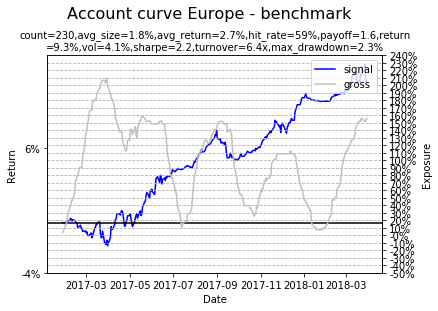

In [28]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,30,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Account curve Europe - benchmark",[6,4])

In [66]:
signal1_rel_df_date_Europe

(1COV GR, 24/Oct/2017, None, None)  \
2017-01-27                                 NaN   
2017-01-30                                 NaN   
2017-01-31                                 NaN   
2017-02-01                                 NaN   
2017-02-02                                 NaN   
2017-02-03                                 NaN   
2017-02-06                                 NaN   
2017-02-07                                 NaN   
2017-02-08                                 NaN   
2017-02-09                                 NaN   
2017-02-10                                 NaN   
2017-02-13                                 NaN   
2017-02-14                                 NaN   
2017-02-15                                 NaN   
2017-02-16                                 NaN   
2017-02-17                                 NaN   
2017-02-20                                 NaN   
2017-02-21                                 NaN   
2017-02-22                                 NaN   
2017-02-23                                 NaN   
2017-02-24                                 NaN   
2017-02-27                                 NaN   
2017-02-28                                 NaN   
2017-03-01                                 NaN   
2017-03-02                                 NaN   
2017-03-03                                 NaN   
2017-03-06                                 NaN   
2017-03-07                                 NaN   
2017-03-08                                 NaN   
2017-03-09                                 NaN   
...                                        ...   
2018-02-19                                 NaN   
2018-02-20                                 NaN   
2018-02-21                                 NaN   
2018-02-22                                 NaN   
2018-02-23                                 NaN   
2018-02-26                                 NaN   
2018-02-27                                 NaN   
2018-02-28                                 NaN   
2018-03-01                                 NaN   
2018-03-02                                 NaN   
2018-03-05                                 NaN   
2018-03-06                                 NaN   
2018-03-07                                 NaN   
2018-03-08                                 NaN   
2018-03-09                                 NaN   
2018-03-12                                 NaN   
2018-03-13                                 NaN   
2018-03-14                                 NaN   
2018-03-15                                 NaN   
2018-03-16                                 NaN   
2018-03-19                                 NaN   
2018-03-20                                 NaN   
2018-03-21                                 NaN   
2018-03-22                                 NaN   
2018-03-23                                 NaN   
2018-03-26                                 NaN   
2018-03-27                                 NaN   
2018-03-28                                 NaN   
2018-03-29                                 NaN   
2018-03-30                                 NaN   

            (ACX SM, 01/Mar/2017, 27/Apr/2017, None)  \
2017-01-27                                       NaN   
2017-01-30                                       NaN   
2017-01-31                                       NaN   
2017-02-01                                       NaN   
2017-02-02                                       NaN   
2017-02-03                                       NaN   
2017-02-06                                       NaN   
2017-02-07                                       NaN   
2017-02-08                                       NaN   
2017-02-09                                       NaN   
2017-02-10                                       NaN   
2017-02-13                                       NaN   
2017-02-14                                       NaN   
2017-02-15                                       NaN   
2017-02-16                                       NaN   
2017-02-17     